## spaCy Notebook

Here is the notebook that will perform Named Entity Recognition using the spaCy module on the not-parsed data set


### Understanding spaCy
Ultimately it will be useful to use spaCy to find names in the publication statements, but first it is important to see what information spaCy can tell us.
<br><br>
Namely, the *labels* of the *entities*. *Labels* being the type of entity, in the example below the labels are PERSON, ORG, DATE etc. Entities are the nouns or information that the model recognizes as unique and specific. In the below example: Sebastian Thrun, Google, 2007 etc. This is different from any noun such as "companies" or "CEOs" which are not specific *Named Entities* and therefore not picked up by the model.
<br><br>
Example from spaCy website:<br>
text= <br>
("When Sebastian Thrun started working on self-driving cars at "<br>
  "Google in 2007, few people outside of the company took him "<br>
  "seriously. “I can tell you very senior CEOs of major American "<br>
  "car companies would shake my hand and turn away because I wasn’t "<br>
  "worth talking to,” said Thrun, in an interview with Recode earlier "<br>
  "this week.")<br>
  <br>
Entity, Label:
* Sebastian Thrun, PERSON
* Google, ORG
* 2007, DATE
* American, NORP
* Thrun, PERSON
* Recode, ORG
* earlier this week, DATE

In [9]:
# Import Necessary Modules
import pandas as pd
import spacy
import re
import matplotlib.pyplot as plt
from collections import Counter
# Load spaCy Model
# requires installing the model with python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

#define path for dataframe
printers_data_file_pubstmt_notparsed = 'data/printers_etc_pubstmt_notparsed.csv'
#create Dataframe
pubstmt_df = pd.read_csv(printers_data_file_pubstmt_notparsed)

In [ ]:
pubstmt_df

### First Steps

It will be useful to figure out what labels are in the publication statements
<br><br>
The below code does this

In [ ]:
# Define function to print entity labels
def return_entity_labels(text):
    doc = nlp(text)
    label_list = []
    for ent in doc.ents:
        label_list.append((ent.label_, ent.text))
    return label_list
# Print entity labels for each row in pubstmt_df['pubStmt']
for stmt in pubstmt_df['pubStmt'][:100]:
    print(return_entity_labels(stmt))

In [ ]:
#it will also be useful to get a list of all labels
def get_entity_labels(text):
    doc = nlp(text)
    labels = set([ent.label_ for ent in doc.ents])
    return labels

all_labels = set()

# Loop through the 'pubStmt' column and add the entity labels to the set
for stmt in pubstmt_df['pubStmt']:
    labels = get_entity_labels(stmt)
    all_labels.update(labels)

# Print the set of all unique entity labels
print(all_labels)

## Next Step

The results from the first tests show that the labels we have in our Publication Statements are: <br>'CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERSON', 'PRODUCT', 'QUANTITY', 'WORK_OF_ART'<br>
The possible labels are: <br> 'CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', *'PERCENT'*, 'PERSON', 'PRODUCT', 'QUANTITY', *'TIME'*, 'WORK_OF_ART'

Also, while spaCy is mostly accurate it sometimes confuses labels, for example:
* Antwerp was labeled as a Person
* XXIX was labeled as a Person
* CCCC was labeled as a Geo-political Entity
* Wylliam Caxton was labeled as an Organization

These errors will be important to address in the future, but next step is to add a column in the dataframe for all named entities that could be the publisher.

## Create a Helper Function
This Function takes:
* a statement to search for names in
* and a Named Entity Recognition Model that can test for names

This Function will be used to extract the names

In [ ]:
#Define a Function for Name Extraction
def extract_names(statement, ner_model):
    ner_in_statement = ner_model(statement) 
    return [ent.text for ent in ner_in_statement.ents if ent.label_ in ["PERSON"]]

In [ ]:
pubstmt_df['namedEntities'] = pubstmt_df['pubStmt'].apply(extract_names, ner_model=nlp)
pubstmt_df['namedEntities']

## "Printed by" statements
In a preliminary exploration of the data the most common pubstatement includes one of the following search strings: "printed by", "printed for", "printed, by", "printed, for","prentyd by","enprynted by", or "imprinted by". The below code demonstrates how many statements include

In [10]:
# concatenate all statements into a single string
all_statements = ' '.join(pubstmt_df['pubStmt'])

# define a list of search strings
search_strings = ["printed by", "printed for", "printed, by", "printed, for","prentyd by","enprynted by", "imprinted by"]

# compile a regular expression pattern to match any of the search strings
pattern = re.compile('({0})'.format('|'.join(search_strings)), re.IGNORECASE)

# find all matches of the pattern in the concatenated statements
matches = pattern.findall(all_statements)

# count the number of matches
match_count = len(matches)

# print the result
print(f'Number of matches: {match_count}')
print(f'Number of publication statements: {pubstmt_df.shape[0]}')
print(f'Percent matches: {match_count/pubstmt_df.shape[0]*100:.3f}%')

Number of matches: 9265
Number of publication statements: 11376
Percent matches: 81.443%


## Investigating these statements

In the majority of these statements the next word is "the" followed by a word that describes who is printing the work  <br>
e.g. "**Printed by** *the* **Societie** of Stationers..."<br>
In this example the societie of stationers are the printers and they are, as expected, notated right after the "printed by" and the formula statement <br>
So it will be helpful to see the most common words that follow this statement as it will consitently describe the printers for 81.44% of this dataset. <br>
The below plot does this and finds that the following words are the most common words in these statements:
* widow
* heir
  * heirs
  * Heir
* deputies
* Society
  * Societie of Stationers
* assigns
  * assignes
  * Assigns
* successors
* Printers to the V/University/ie of...
  * printers
* Kings most excellent Majestie
* generall sataisfaction of...
* author
* use


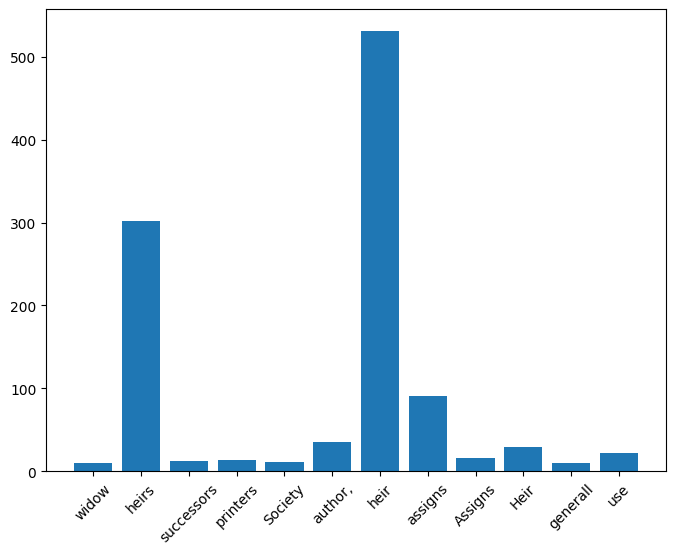

In [11]:
# search strings
search_strings = ["printed by", "printed for", "printed, by", "printed, for","prentyd by","enprynted by", "imprinted by"]

words_list = []
# iterate over search strings and search for them in pubStmt column
for search_str in search_strings:
    mask = pubstmt_df['pubStmt'].str.contains(search_str, case=False)
    if mask.any():
        # if a match is found, extract the three words after the search string and print them
        pubStmt_filtered = pubstmt_df[mask]['pubStmt']
        for pubStmt in pubStmt_filtered:
            search_str_idx = pubStmt.lower().index(search_str)
            words_after = pubStmt[search_str_idx+len(search_str):].split()
            if words_after[0] == 'the' or words_after[0] == 'The':
                words_list.append(words_after[1])
            #print(f"{search_str} {' '.join(words_after[:3])}")
words_counter = Counter(words_list)
cutoff = 10
words_counter = {word: count for word,count in words_counter.items() if count>=cutoff}
words_list, count_list = zip(*words_counter.items())
words_list=list(words_list)

plt.figure(figsize=(8,6))

plt.bar(words_list, count_list)
plt.xticks(rotation=45)
plt.show()
